<a href="https://colab.research.google.com/github/hyunchangyi/dxy/blob/main/dnn_dxy_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hyunchangyi/dxy.git

Cloning into 'dxy'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [8]:
%pip install pandas==1.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.7 MB 4.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [1]:
%run dxy/dxy_forecast

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
cv = ['inf', 'un', 'bill', 'note', 'bond', 'dp', 'pe', 'sret12', 'iv', 'is']
gv = ['epu', 'mpu', 'gr', 'gvol', 'gill', 'gcor', 't10', 't5', 'vix', 'ted']
sds = ['s', 'ds']

In [3]:
def build_dnn(l1_reg, l2_reg, n_input):
    dnn = Sequential()
    dnn.add(Dense(16, activation=LeakyReLU(alpha=0.01), use_bias=False, input_shape=(n_input,),    
                  kernel_regularizer=regularizers.L1L2(l1=l1_reg, l2=l2_reg) ))
    dnn.add(Dropout(0.5))
    dnn.add(Dense(8, activation=LeakyReLU(alpha=0.01), use_bias=False,
                  kernel_regularizer=regularizers.L1L2(l1=l1_reg, l2=l2_reg) ))
    dnn.add(Dropout(0.5))
    dnn.add(Dense(4, activation=LeakyReLU(alpha=0.01), use_bias=False,
                  kernel_regularizer=regularizers.L1L2(l1=l1_reg, l2=l2_reg) ))
    dnn.add(Dropout(0.5))
    dnn.add(Dense(2, activation=LeakyReLU(alpha=0.01), use_bias=False,
                  kernel_regularizer=regularizers.L1L2(l1=l1_reg, l2=l2_reg) ))
    dnn.add(Dense(1, activation=LeakyReLU(alpha=0.01), use_bias=False,
                  kernel_regularizer=regularizers.L1L2(l1=l1_reg, l2=l2_reg) ))
    dnn.compile(optimizer='adam', loss='mse', metrics=['mse'])  
    return dnn

# DXY

## Full

In [4]:
X, y = read_Xy('dxy/pickles/Xsdsm.pkl', 'dxy/pickles/ym.pkl')
y = y.unstack()[co6].dot(dxy_weight)
X = X.unstack()

In [8]:
X_train.shape

(191, 1220)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, shuffle=False)

n_input = X.shape[1]

res = pd.DataFrame(columns = ['l1', 'l2', 'n_epochs', 'N', 'dropout', 'r2'])

        
for i, j, n_epochs, N in tqdm(itertools.product([0.3], [6.0], [500], [10])):
    
    l1 = 1e-7*i
    l2 = 1e-5*j
    
    dnn = build_dnn(l1, l2, X.shape[1])
    dnn.save_weights('dnn.h5')
    
    dnn_p = 0
    
    for q in range(N):
        dnn.fit(X_train, y_train, epochs=n_epochs, batch_size=32, verbose=0)
        dnn_p += dnn.predict(X_test).squeeze()
        dnn.load_weights('dnn.h5')
    
    dnn_p = dnn_p / N
    
    error = y_test - dnn_p
    r2 = (1 - np.sum(error**2)/np.sum(y_test**2))

    df = pd.DataFrame([[l1, l2, n_epochs, N, r2]], columns = ['l1', 'l2', 'n_epochs', 'N', 'r2'])
    res = pd.concat([res, df], axis=0)
    
    # print(f'l1: {l1_reg*1e6:.5f} E-6,\t l2: {l2_reg*1e6:.5f} E-6,\t MSE: {score[1]*1e3:.3f} E-3,\t R2: {r2*1e3:+6.4f} E-3')

0it [00:00, ?it/s]

3/3 [==============================] - 0s 2ms/step


1it [01:22, 82.74s/it]


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
res.groupby(['l1', 'l2'])['r2'].agg(['mean']).sort_values('mean', ascending=False).head(10)

mean
l1           l2                
5.000000e-08 0.000065  0.056788
             0.000060  0.055911
3.000000e-08 0.000055  0.054789
             0.000060  0.054305
5.000000e-08 0.000055  0.052956
4.000000e-08 0.000060  0.051308
             0.000055  0.047183
             0.000065  0.044090
3.000000e-08 0.000065  0.037803

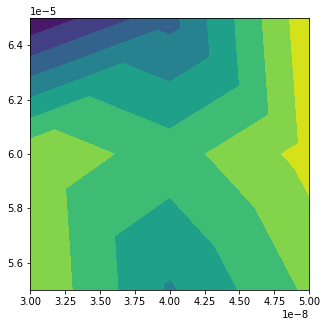

In [ ]:
df = res.groupby(['l1', 'l2'], as_index=False)['r2'].mean()
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.tricontourf(df.l1, df.l2, df.r2)

In [ ]:
res.groupby(['l1', 'l2'])['r2'].agg(['mean']).sort_values('mean', ascending=False).head(10)

mean
l1           l2               
6.000000e-08 0.00006  0.060511
             0.00005  0.058887
8.000000e-08 0.00004  0.058048
1.400000e-07 0.00006  0.057206
             0.00004  0.056243
1.200000e-07 0.00005  0.055251
6.000000e-08 0.00004  0.053523
1.200000e-07 0.00004  0.053483
8.000000e-08 0.00005  0.053332
1.000000e-07 0.00005  0.052861

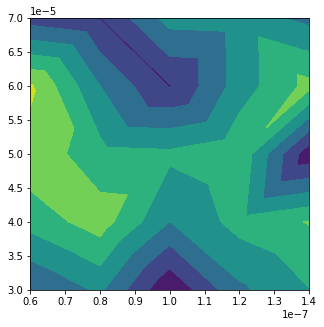

In [ ]:
df = res.groupby(['l1', 'l2'], as_index=False)['r2'].mean()
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.tricontourf(df.l1, df.l2, df.r2)

In [ ]:
res.groupby(['l1', 'l2'])['r2'].agg(['mean']).sort_values('mean', ascending=False).head(10)

,,,,mean,min,std,count
l1,l2,n_epochs,N,,,,
1.000000e-06,0.000025,500,10,0.056938,0.056938,NaN,1
1.000000e-07,0.000050,500,10,0.053452,0.053452,NaN,1
5.000000e-07,0.000050,500,10,0.049415,0.049415,NaN,1
1.000000e-09,0.000050,500,10,0.048409,0.048409,NaN,1
1.000000e-08,0.000050,500,10,0.048024,0.048024,NaN,1
5.000000e-08,0.000050,500,10,0.047820,0.047820,NaN,1
5.000000e-07,0.000025,500,10,0.043386,0.043386,NaN,1
1.000000e-07,0.000025,500,10,0.039066,0.039066,NaN,1
5.000000e-08,0.000025,500,10,0.036544,0.036544,NaN,1


In [ ]:
res.to_pickle('dnn_tunning_dxy_full_1.pkl')

In [ ]:
res = pd.read_pickle('dnn_tunning_dxy_full_1.pkl')

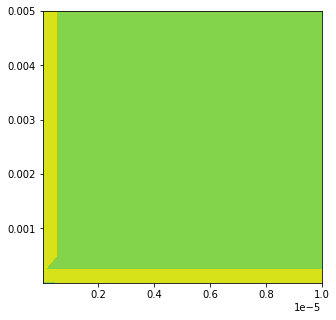

In [ ]:
df = res.groupby(['l1', 'l2'], as_index=False)['r2'].mean()

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.tricontourf(df.l1, df.l2, df.r2)

## Small

In [ ]:
X, y = read_Xy('Xsdsm.pkl', 'ym.pkl')
X = X[sds + cv + gv]
y = y.unstack()[co6].dot(dxy_weight)
X = X.unstack()

In [ ]:
X, y = read_Xy('Xsdsm.pkl', 'ym.pkl')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, shuffle=False)

n_input = X.shape[1]

res = pd.DataFrame(columns = ['l1', 'l2', 'n_epochs', 'N', 'dropout', 'r2'])
        
for i, j, n_epochs, N in tqdm(itertools.product([1.4, 1.2, 1, 0.8, 0.6], [1.4, 1.2, 1, 0.8, 0.6], [500], [10])):
    
    l1 = 1e-7*i
    l2 = 5e-5*j
        
    pre = dnn_ensemble(X_train, X_test, y_train, y_test, n_input, l1, l2, n_epochs, N)
    
    error = y_test - pre
    r2 = (1 - np.sum(error**2)/np.sum(y_test**2))

    df = pd.DataFrame([[l1, l2, n_epochs, N, r2]], columns = ['l1', 'l2', 'n_epochs', 'N', 'r2'])
    res = pd.concat([res, df], axis=0)
    
    # print(f'l1: {l1_reg*1e6:.5f} E-6,\t l2: {l2_reg*1e6:.5f} E-6,\t MSE: {score[1]*1e3:.3f} E-3,\t R2: {r2*1e3:+6.4f} E-3')

25it [1:49:37, 263.10s/it]


In [ ]:
res.groupby(['l1', 'l2'])['r2'].agg(['mean']).sort_values('mean', ascending=False).head(10)

mean
l1           l2               
6.000000e-08 0.00005  0.061995
8.000000e-08 0.00005  0.057952
1.400000e-07 0.00004  0.057050
1.200000e-07 0.00004  0.054502
6.000000e-08 0.00004  0.053468
             0.00007  0.053259
1.200000e-07 0.00007  0.051598
8.000000e-08 0.00007  0.049484
1.000000e-07 0.00004  0.048644
             0.00007  0.047646

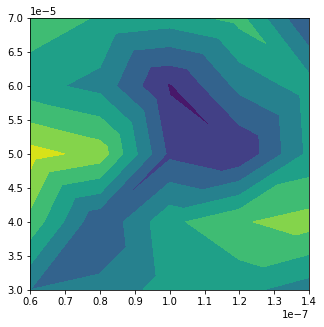

In [ ]:
df = res.groupby(['l1', 'l2'], as_index=False)['r2'].mean()
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.tricontourf(df.l1, df.l2, df.r2)

In [ ]:
res.groupby(['l1', 'l2', 'n_epochs', 'N'])['r2'].agg(['mean', 'min', 'std', 'count']).sort_values('mean', ascending=False).head(10)

,,,,mean,min,std,count
l1,l2,n_epochs,N,,,,
1.000000e-08,0.000050,500,10,0.061025,0.061025,NaN,1
5.000000e-08,0.000050,500,10,0.057805,0.057805,NaN,1
5.000000e-07,0.000025,500,10,0.050759,0.050759,NaN,1
1.000000e-09,0.000050,500,10,0.047527,0.047527,NaN,1
1.000000e-07,0.000050,500,10,0.045695,0.045695,NaN,1
1.000000e-06,0.000025,500,10,0.044406,0.044406,NaN,1
1.000000e-08,0.000025,500,10,0.040531,0.040531,NaN,1
1.000000e-06,0.000050,500,10,0.039457,0.039457,NaN,1
1.000000e-07,0.000025,500,10,0.036690,0.036690,NaN,1


In [ ]:
res.to_pickle('dnn_tunning_dxy_small_1.pkl')

In [ ]:
res = pd.read_pickle('dnn_tunning_dxy_small_1.pkl')

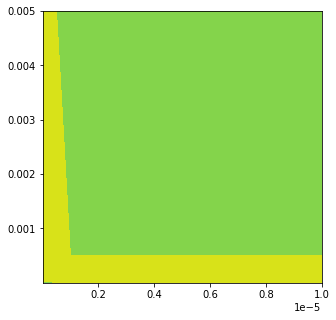

In [ ]:
df = res.groupby(['l1', 'l2'], as_index=False)['r2'].mean()

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.tricontourf(df.l1, df.l2, df.r2)

In [ ]:
res.loc[res.l2 < 0.005].groupby(['l1', 'l2', 'n_epochs', 'N'])['r2'].agg(['mean', 'min', 'std', 'count']).sort_values('mean', ascending=False).head(10)

,,,,mean,min,std,count
l1,l2,n_epochs,N,,,,
1.000000e-08,0.000050,500,10,0.061025,0.061025,NaN,1
5.000000e-08,0.000050,500,10,0.057805,0.057805,NaN,1
5.000000e-07,0.000025,500,10,0.050759,0.050759,NaN,1
1.000000e-09,0.000050,500,10,0.047527,0.047527,NaN,1
1.000000e-07,0.000050,500,10,0.045695,0.045695,NaN,1
1.000000e-06,0.000025,500,10,0.044406,0.044406,NaN,1
1.000000e-08,0.000025,500,10,0.040531,0.040531,NaN,1
1.000000e-06,0.000050,500,10,0.039457,0.039457,NaN,1
1.000000e-07,0.000025,500,10,0.036690,0.036690,NaN,1


In [ ]:
res.loc[res.l1 == 1e-8].groupby(['l1', 'l2', 'n_epochs', 'N'])['r2'].agg(['mean', 'min', 'std', 'count']).sort_values('mean', ascending=False).head(10)

mean       min  std  count
l1           l2           n_epochs N                                 
1.000000e-08 5.000000e-05 500      10  0.061025  0.061025  NaN      1
             2.500000e-05 500      10  0.040531  0.040531  NaN      1
             2.500000e-04 500      10  0.000000  0.000000  NaN      1
             5.000000e-04 500      10  0.000000  0.000000  NaN      1
             5.000000e-03 500      10  0.000000  0.000000  NaN      1
             5.000000e-06 500      10 -0.031950 -0.031950  NaN      1
             5.000000e-07 500      10 -0.282042 -0.282042  NaN      1